In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import clip
from PIL import Image
import open_clip
import csv

/opt/anaconda3/envs/NN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set device and load models
device = "cuda" if torch.cuda.is_available() else "mps"
# Load the pre-trained CLIP model and tokenizer
model, _, preprocess = open_clip.create_model_and_transforms("ViT-H-14-378-quickgelu", pretrained="dfn5b", device=device)

In [7]:
# Function to assess realism of an image
def iqa(image_path, description="A good photo."):
    # show the image without grid
    # plt.axis('off')
    # plt.imshow(Image.open(image_path))
    # plt.show()

    # Load and preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Tokenize the textual description
    text = open_clip.tokenize([description]).to(device)
    
    # Calculate the similarity between the image and the text
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        # Normalize features for cosine similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity score
        similarity = (image_features @ text_features.T).item()
        
        # or we can use euclidean distance here
        # similarity = torch.norm(image_features - text_features, dim=-1).item()


    # Print the similarity score
    # print(f"Alignment score: {similarity:.2f}")
    # if similarity > 0.25: # threshold can be adjusted
    #     print(f"Yes, the photo aligns with the description: {description}.")
    # else:
    #     print(f"No, the photo does not align with the description: {description}.")
    return similarity

we try a real example here

In [5]:
prompt = """Create a poster for an NYU Shanghai guest lecture event with these specifications: 
- Use NYU's official violet color (#57068c) 
- Include NYU Shanghai logo placement area at top 
- Event Title: "Future of AI in Business" 
- Speaker: Dr. Sarah Chen, Google AI Research 
- Date: November 15, 2024, 4-6 PM
- Location: Room 1555
- Style: Professional, corporate, academic
- Must include: Registration QR code placeholder
- Layout: Vertical A3 poster' """

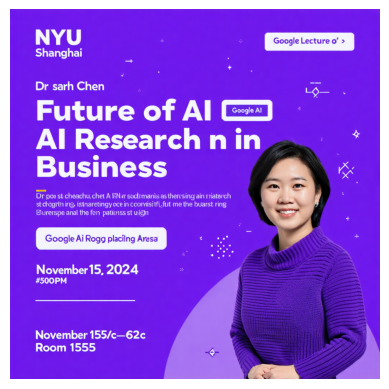

Alignment score: 0.50
Yes, the photo aligns with the description: Create a poster for an NYU Shanghai guest lecture event with these specifications: 
- Use NYU's official violet color (#57068c) 
- Include NYU Shanghai logo placement area at top 
- Event Title: "Future of AI in Business" 
- Speaker: Dr. Sarah Chen, Google AI Research 
- Date: November 15, 2024, 4-6 PM
- Location: Room 1555
- Style: Professional, corporate, academic
- Must include: Registration QR code placeholder
- Layout: Vertical A3 poster' .


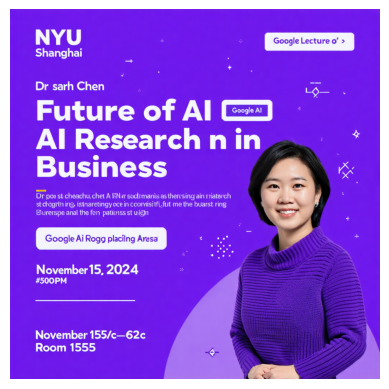

Alignment score: 0.40
Yes, the photo aligns with the description: poster for a NYU Shanghai guest lecture event.


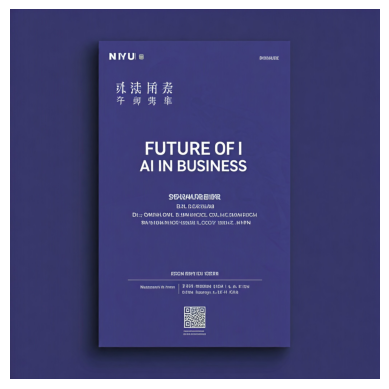

Alignment score: 0.40
Yes, the photo aligns with the description: Create a poster for an NYU Shanghai guest lecture event with these specifications: 
- Use NYU's official violet color (#57068c) 
- Include NYU Shanghai logo placement area at top 
- Event Title: "Future of AI in Business" 
- Speaker: Dr. Sarah Chen, Google AI Research 
- Date: November 15, 2024, 4-6 PM
- Location: Room 1555
- Style: Professional, corporate, academic
- Must include: Registration QR code placeholder
- Layout: Vertical A3 poster' .


0.39587438106536865

In [6]:
iqa('test_image/sd_poster.png', prompt)
iqa('test_image/sd_poster.png', 'poster for a NYU Shanghai guest lecture event')
iqa('test_image/google_poster.jpeg', prompt)

In [8]:
data_folder= 'data'
output_csv = "iqa_scores.csv"

In [9]:
prompt_1 = """
Create a poster for an NYU Shanghai guest lecture event with these specifications: 
- Use NYU's official violet color (#57068c) 
- Include NYU Shanghai logo placement area at top 
- Event Title: "Future of AI in Business" 
- Speaker: Dr. Sarah Chen, Google AI Research 
- Date: November 15, 2024, 4-6 PM
- Location: Room 1555
- Style: Professional, corporate, academic
- Must include: Registration QR code placeholder
- Layout: Vertical A3 poster
"""

prompt_2 = """
Design a Chinese New Year celebration poster for NYU Shanghai:
- Title in English and Chinese: "Spring Festival Gala 2024" / "2024年春节晚会"
- Blend modern university aesthetic with traditional Chinese elements
- Include both dragon imagery (2024 zodiac) and NYU torch
- Color scheme: NYU violet with traditional red and gold
- Include student performance details in both languages
- Style: Contemporary fusion of East and West
- Format: Square poster for both print and social media
"""

prompt_3 = """
Create an academic conference poster with complex information:
- Title: "Global Business Innovation Summit 2024"
- Include: 
  * 4 keynote speaker sections with photo placeholders
  * Conference schedule with 3 parallel tracks
  * 6 sponsor logo placeholders
  * Registration information
  * Contact details
- Must be scannable in 5 seconds for key information
- Professional academic style
- Size: A2 vertical format
"""

prompt_4 = """
Design a student club fair poster with these elements:
- Theme: "Discover Your Passion"
- Style: Dynamic, youthful, energetic
- Must include:
  * Abstract geometric shapes
  * Movement suggestion through design
  * Space for 30+ club names
  * High contrast for readability
  * Interactive elements (phone camera icon for AR)
- Target audience: Gen Z students
- Format: A1 size, portrait orientation
- Color scheme: Vibrant but professional
"""

prompts = {
    "prompt_1": prompt_1,
    "prompt_2": prompt_2,
    "prompt_3": prompt_3,
    "prompt_4": prompt_4
}

In [10]:
# Function to process all images and collect scores
def process_images():
    # Prepare to write CSV
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Prompt", "Image", "Score"])
        # Iterate through each model folder
        for model_folder in os.listdir(data_folder):

            model_path = os.path.join(data_folder, model_folder)
            if os.path.isdir(model_path):
                
                # Iterate through each prompt folder inside the model folder
                for prompt_folder in os.listdir(model_path):
                    prompt_path = os.path.join(model_path, prompt_folder)
                    if os.path.isdir(prompt_path):
                        
                        # Iterate through each image in the prompt folder
                        for image_name in os.listdir(prompt_path):
                            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                                image_path = os.path.join(prompt_path, image_name)

                                # Run the iqa function and get the score
                                score = iqa(image_path, description=prompts[prompt_folder])

                                # Write the result to CSV
                                writer.writerow([model_folder, prompt_folder, image_name, score])
                                print(f"Processed {image_name} in {model_folder}/{prompt_folder} with score {score:.2f}")
                            else:
                                print(f"Skipping non-image file {image_name}")
                    else:
                        print(f"Skipping non-directory file {prompt_folder}")
            else:
                print(f"Skipping non-directory file {model_folder}")


In [11]:
process_images()

Skipping non-directory file .DS_Store
Processed WechatIMG75.jpg in stability_ai/prompt_2 with score 0.40
Processed WechatIMG74.jpg in stability_ai/prompt_2 with score 0.43
Processed WechatIMG73.jpg in stability_ai/prompt_2 with score 0.42
Processed WechatIMG72.jpg in stability_ai/prompt_2 with score 0.41
Processed WechatIMG79.jpg in stability_ai/prompt_3 with score 0.42
Processed WechatIMG78.jpg in stability_ai/prompt_3 with score 0.45
Processed WechatIMG76.jpg in stability_ai/prompt_3 with score 0.43
Processed WechatIMG77.jpg in stability_ai/prompt_3 with score 0.44
Processed WechatIMG83.jpg in stability_ai/prompt_4 with score 0.44
Processed WechatIMG82.jpg in stability_ai/prompt_4 with score 0.42
Processed WechatIMG80.jpg in stability_ai/prompt_4 with score 0.47
Processed WechatIMG81.jpg in stability_ai/prompt_4 with score 0.40
Processed WechatIMG68.jpg in stability_ai/prompt_1 with score 0.43
Processed WechatIMG69.jpg in stability_ai/prompt_1 with score 0.44
Processed WechatIMG70.jp

In [6]:
# get the data from the csv file
df = pd.read_csv('iqa_scores.csv')
df.head()

,Model,Prompt,Image,Score
0,stability_ai,prompt_2,WechatIMG75.jpg,0.404490
1,stability_ai,prompt_2,WechatIMG74.jpg,0.432440
2,stability_ai,prompt_2,WechatIMG73.jpg,0.421430
3,stability_ai,prompt_2,WechatIMG72.jpg,0.411050
4,stability_ai,prompt_3,WechatIMG79.jpg,0.418409


In [7]:
# group the data by model
df_grouped = df.groupby('Model')['Score'].mean().sort_values(ascending=False)
df_grouped


Model
openai          0.457899
stability_ai    0.428772
meta            0.425932
microsoft       0.412953
akool           0.412274
midjourney      0.400473
google          0.385988
Name: Score, dtype: float64

In [9]:
df_grouped = df.groupby('Prompt')['Score'].mean().sort_values(ascending=False)
df_grouped

Prompt
prompt_1    0.426914
prompt_2    0.422699
prompt_3    0.418417
prompt_4    0.402994
Name: Score, dtype: float64

In [27]:
import scipy.stats as stats

# Performing ANOVA to compare the means of scores across different models
anova_model = stats.f_oneway(*[group['Score'].values for name, group in df.groupby('Model')])

# Performing ANOVA to compare the means of scores across different prompts
anova_prompt = stats.f_oneway(*[group['Score'].values for name, group in df.groupby('Prompt')])

# Display the ANOVA results
anova_model, anova_prompt

(F_onewayResult(statistic=8.895577771651073, pvalue=7.585936620208251e-08),
 F_onewayResult(statistic=2.33658400343788, pvalue=0.07776497396253214))

In [35]:
df_grouped = df.groupby('Model')['Score'].var().sort_values(ascending=True)
df_grouped

Model
openai          0.000184
stability_ai    0.000520
google          0.000985
midjourney      0.001074
microsoft       0.001132
meta            0.001213
akool           0.001525
Name: Score, dtype: float64

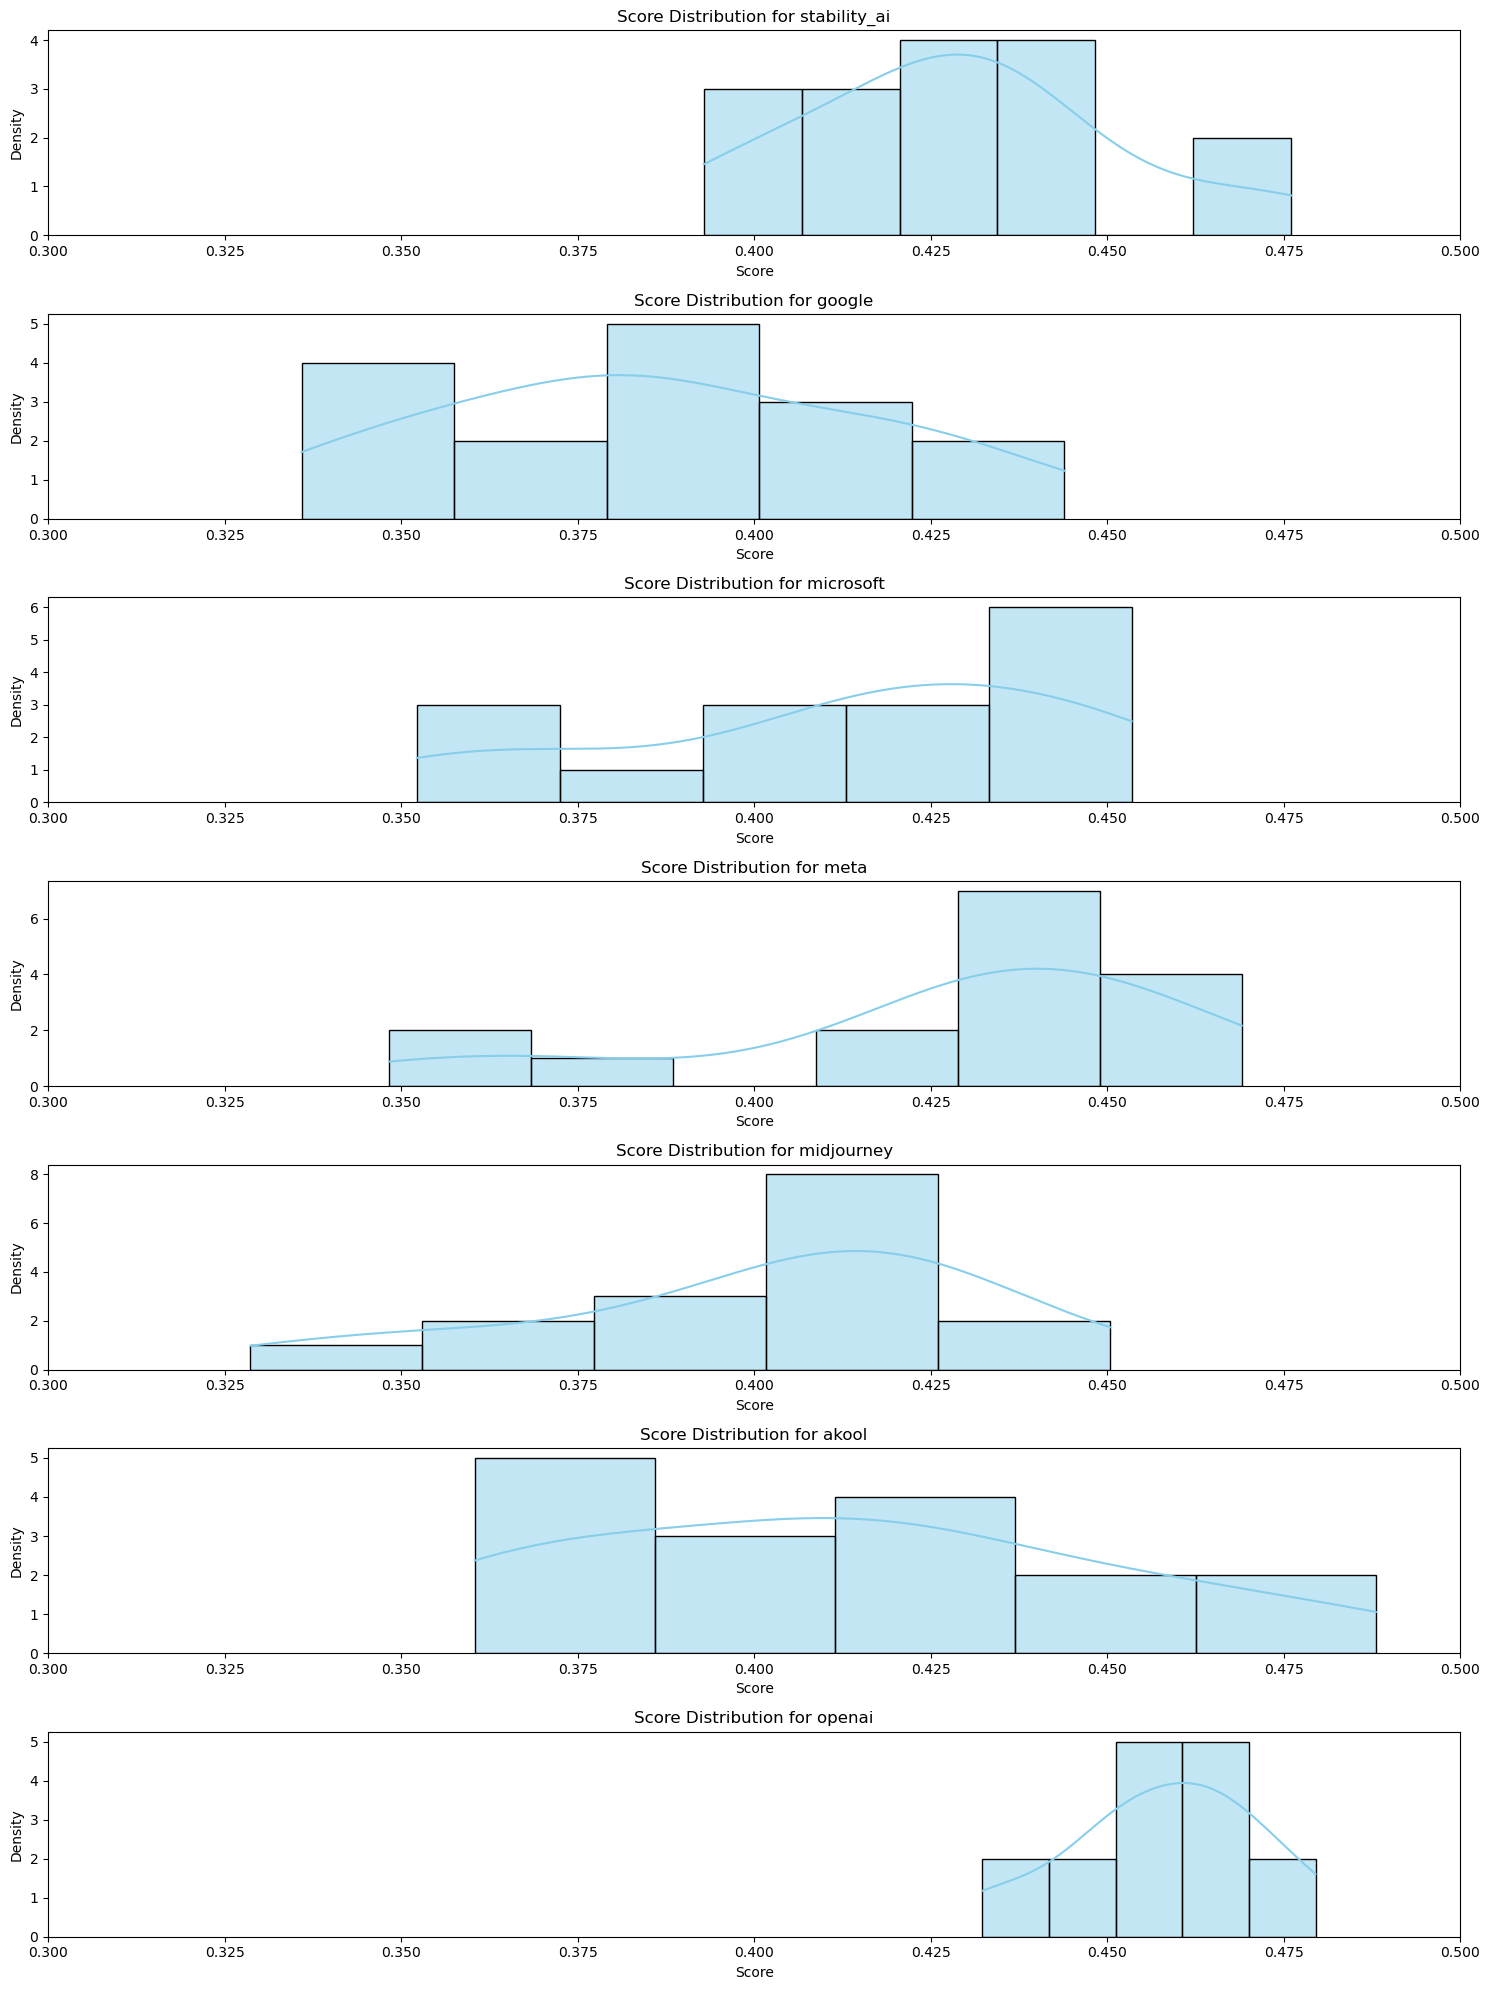

In [34]:
import seaborn as sns
# Plotting individual distributions for each model
models = df['Model'].unique()

# Setting up the figure for multiple subplots
plt.figure(figsize=(15, 20))

# Loop through each model and plot its distribution separately
for i, model in enumerate(models, 1):
    plt.subplot(len(models), 1, i)
    sns.histplot(df[df['Model'] == model]['Score'], kde=True, color='skyblue')
    plt.title(f'Score Distribution for {model}')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.xlim(0.3, 0.5)  # Setting a consistent x-axis range across all plots

plt.tight_layout()
plt.show()